In [ ]:
import pandas as pd
import numpy as np
import os

import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib
from madrigal.evaluate.predict import get_data_for_analysis, make_predictions
from madrigal.evaluate.metrics import get_metrics, get_metrics_binary
from madrigal.utils import BASE_DIR
%matplotlib inline

In [2]:
raw_drugbank_df = pd.read_pickle('../raw_drugbank_df.pkl')

drug_metadata = pd.read_pickle(os.path.join(BASE_DIR, 'processed_data/views_features_new/combined_metadata_ddi.pkl'))
drug_metadata['view_str'] = 1
drug_metadata = drug_metadata[drug_metadata['drugbank_ddi'] == 1].reset_index().merge(raw_drugbank_df, left_on='node_id', right_on='drugbank_id', how='left')
drug_metadata = drug_metadata.set_index('drug_index')

to_keep = ['node_id', 'drug_name', 'moa', 'description', 'indication_y', 'pharmacodynamics', 'view_str']
drug_metadata = drug_metadata[to_keep]

## Label stratified

In [ ]:
data_source = "DrugBank"
split_method = "split_by_drugs_random"
epoch = None
repeat = None
kg_encoder = "hgt"
device = torch.device("cpu")

checkpoint_dir = BASE_DIR + f"model_output/{data_source}/{split_method}/major-waterfall-304/"

train_batches, _, test_batches_1, label_map = get_data_for_analysis(
    data_source=data_source, kg_encoder=kg_encoder, split_method=split_method, repeat=repeat, 
    path_base=BASE_DIR+"processed_data/", checkpoint_dir=checkpoint_dir
    )

In [4]:
def get_label_metrics(model_type, checkpoint, eval_type):
    checkpoint_dir = BASE_DIR + f"model_output/{data_source}/{split_method}/{checkpoint}"
    ckpt = checkpoint_dir + "best_model.pt"
    
    if model_type == 'str_ablation':
        finetune_mode = "ablation_str_str"
    else:
        finetune_mode = "str_str+random_sample"
    
    # test between
    batch = test_batches_1[0]
    ddi_labels = batch['edge_indices']['label']
    ddi_pos_neg_samples = batch['edge_indices']['pos_neg'].float()
    true_ddis = ddi_pos_neg_samples
    label_map_valid = np.array(label_map)[np.unique(ddi_labels)]
    
    pred_ddis = make_predictions(ckpt, 
                                 batch, 
                                 eval_type, 
                                 finetune_mode, 
                                 device)  # expect to see two printings of missing keys, the first one containing "covariates_embeddings.0.weight"

    metrics, pos_samples = get_metrics(
        pred_ddis.numpy(), 
        true_ddis.numpy(), 
        ddi_labels.numpy(), 
        k=50, 
        task='multiclass', 
        average=None, 
        logger=None, 
        verbose=False, 
    )

    # assert label_map_valid.shape[0] == len(label_map)
    test_between_scores = pd.DataFrame({
        "label_ind":np.unique(ddi_labels),
        'label':label_map_valid, 
        'specificity':metrics['specificity'], 
        'npv':metrics['npv'], 
        'auprc':metrics['auprc'], 
        'auroc':metrics['auroc'], 
        'num_pos_sample':pos_samples.astype(int)
    }).sort_values('label')
    
    return pred_ddis, test_between_scores

In [ ]:
_, str_scores = get_label_metrics(model_type='str_ablation', 
                  checkpoint="swift-water-311/", 
                  eval_type='full_full')

In [ ]:
_, no_pretrain_scores = get_label_metrics(model_type='no_pretrain', 
                  checkpoint="frosty-donkey-308/",
                  eval_type='str_full')

In [ ]:
_, pretrain_scores = get_label_metrics(model_type='pretrain', 
                  checkpoint="major-waterfall-304/",
                  eval_type='str_full')

In [9]:
all_metrics = pd.DataFrame({'label':pretrain_scores['label'], 
                            'Struc. only\nw/o CL': str_scores['auprc'],
                            'W/o CL': no_pretrain_scores['auprc'],
                            'Madrigal': pretrain_scores['auprc']})
all_metrics_long = all_metrics.melt(value_vars=['Struc. only\nw/o CL', 'W/o CL', 'Madrigal'], var_name='Model type', value_name='AUPRC')

from scipy.stats import wilcoxon
print(wilcoxon(str_scores['auprc'], no_pretrain_scores['auprc'], alternative='two-sided'))
print(wilcoxon(no_pretrain_scores['auprc'], pretrain_scores['auprc'], alternative='two-sided'))

WilcoxonResult(statistic=1083.0, pvalue=4.951661716243977e-15)
WilcoxonResult(statistic=2773.0, pvalue=0.00015773498094126697)


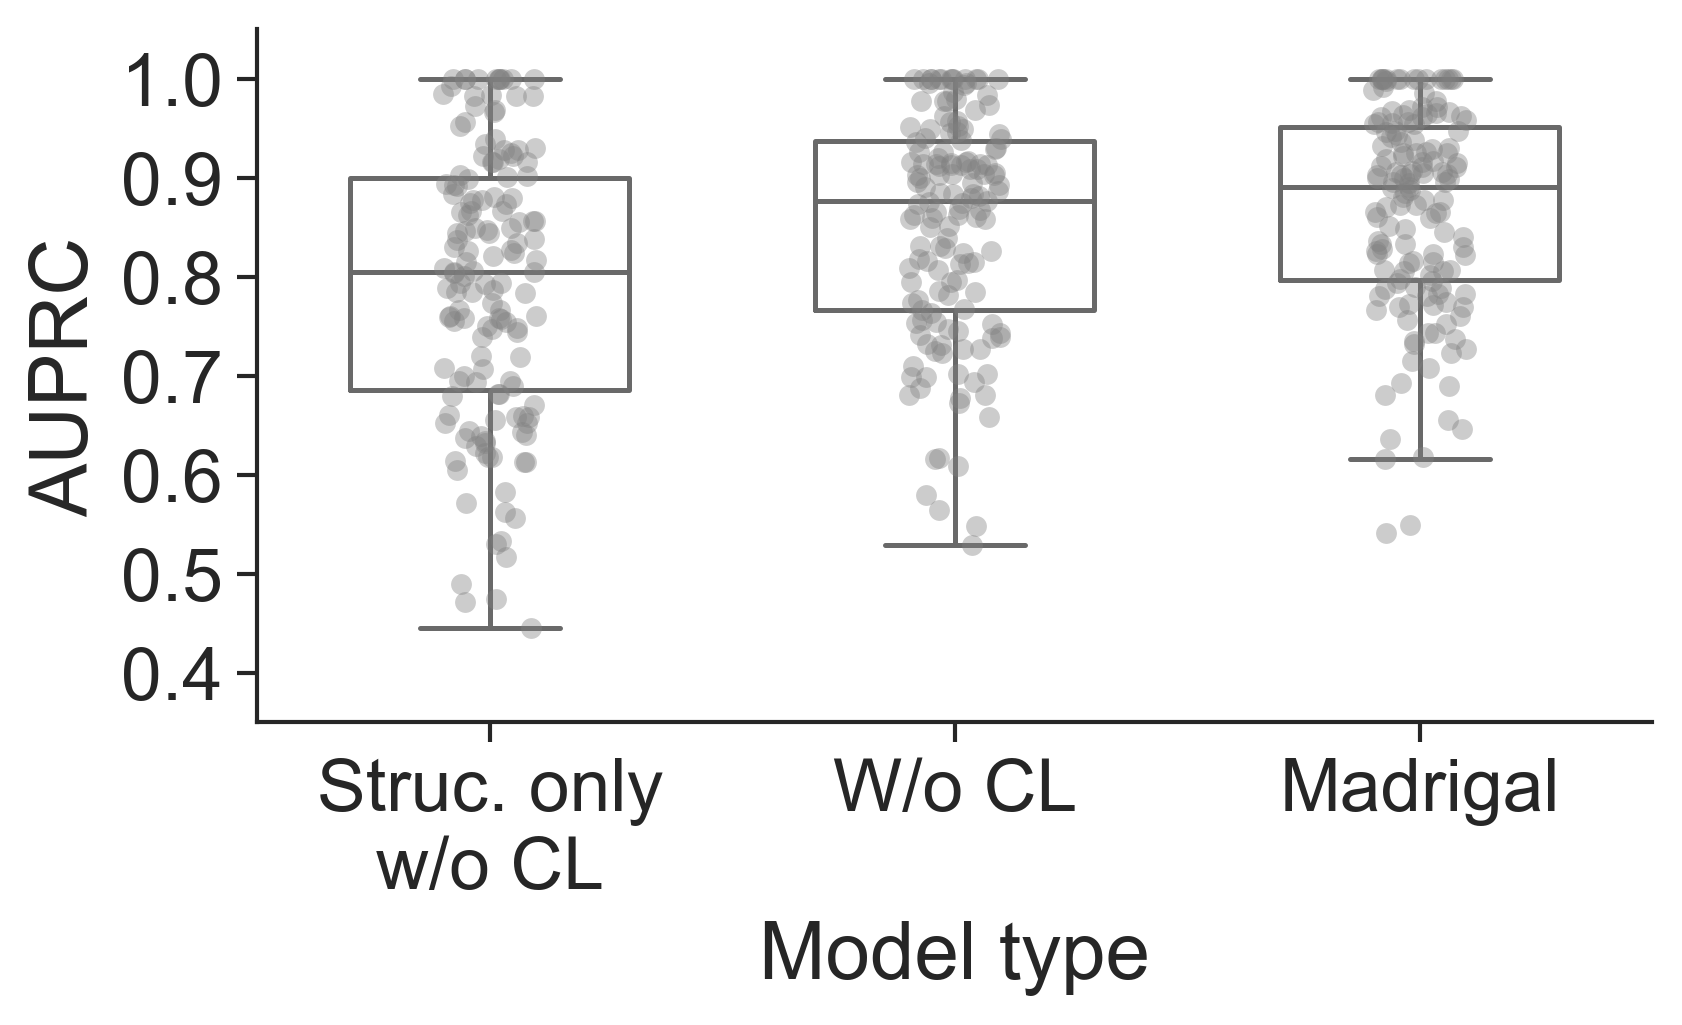

In [14]:
import seaborn as sns
from matplotlib import font_manager as fm
arial_path = "../arial.ttf"
fm.fontManager.addfont(arial_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.figure(figsize=(6, 3), dpi=300)

sns.set(style="ticks", context="paper", font_scale=2)
ax = sns.boxplot(data=all_metrics_long, x="Model type", y="AUPRC", 
                 showfliers=False,
                 fill=False, color="dimgrey", width=0.6)
sns.stripplot(data=all_metrics_long, x="Model type", y="AUPRC", ax=ax, color="grey", alpha=0.4)

# plt.title("Label-stratified AUPRC")
plt.ylim(0.35, 1.05)
plt.yticks(np.arange(0.4, 1.01, 0.1))
sns.despine()
plt.savefig('./fig2_label_stratified_model_comparison.svg', dpi=300, format="svg")
plt.show()

## Drug stratified (modality availability)

In [ ]:
import copy
from itertools import combinations

batch = copy.deepcopy(test_batches_1[0])
between_train_drugs = batch['tail']['drugs'].cpu().numpy()
between_test_drugs = batch['head']['drugs'].cpu().numpy()

between_train_drugs_modality_availability = drug_metadata[[col for col in drug_metadata.columns if col.startswith('view_')]].loc[between_train_drugs]
between_train_drug_to_index = {k:i for i,k in enumerate(between_train_drugs_modality_availability.index)}

view_tx_columns = [col for col in between_train_drugs_modality_availability.columns if col.startswith('view_tx')]

# Step 2: Identify the other columns
other_columns = [col for col in between_train_drugs_modality_availability.columns if not col.startswith('view_tx')]

# TRAIN
# Step 3: Filter rows
# For 'view_tx' columns, check if any column has a value of 1
condition_tx_train = between_train_drugs_modality_availability[view_tx_columns].any(axis=1)

# For the other columns, check if all have a value of 1
condition_others_train = between_train_drugs_modality_availability[other_columns].all(axis=1)

# Apply conditions
between_train_all_modality_available = between_train_drugs_modality_availability[condition_tx_train & condition_others_train].index.tolist()

between_train_set_all_modality = set(between_train_all_modality_available)
keep_ddi_train_full = []
for i, drug_t in tqdm(enumerate(batch["edge_indices"]["tail"])):
    if batch["tail"]["drugs"][drug_t].item() in between_train_set_all_modality:
        keep_ddi_train_full.append(i)

1165476it [00:04, 250848.68it/s]
1165476it [00:04, 245325.00it/s]
1165476it [00:06, 187372.66it/s]


In [ ]:
def batch_mask_mutate(batch, full_modality_drug_inds, avail_mods, head_or_tails):
    """
    If controling modalities for test drugs, `head_or_tails` = ["head"];
    If controling modalities for train drugs, `head_or_tails` = ["tail"];
    o.w. `head_or_tails` = ["head", "tail"].
    """
    to_force_mask = list(set([0,1,2,3]) - set(avail_mods))
    
    for head_or_tail in head_or_tails:
        for i in range(len(batch[head_or_tail]["drugs"])):
            if batch[head_or_tail]["drugs"][i].item() in full_modality_drug_inds:
                for j in to_force_mask:
                    if j < 3:
                        batch[head_or_tail]["masks"][i, j] = True
                    else:
                        batch[head_or_tail]["masks"][i, 3:] = True
    
    return batch

In [ ]:
def get_label_metrics_all_mod_train(model_type, checkpoint, eval_type, full_mod_drug_set, keep_ddi, head_or_tails = ["head"]):
    checkpoint_dir = BASE_DIR + f"model_output/{data_source}/{split_method}/{checkpoint}"
    ckpt = checkpoint_dir + "best_model.pt"
    finetune_mode = "str_str+random_sample"
        
    batch = test_batches_1[0]
    ddi_pos_neg_samples = batch["edge_indices"]["pos_neg"].float()
    true_ddis = ddi_pos_neg_samples
    
    avail_mods_all_combs = [()] + list(combinations([1,2,3], 1)) + list(combinations([1,2,3], 2)) + list(combinations([1,2,3], 3))
    all_auprc = []
    
    for avail_mods in tqdm(avail_mods_all_combs):
        avail_mods = [0] + list(avail_mods)
        new_batch = batch_mask_mutate(copy.deepcopy(batch), full_mod_drug_set, avail_mods, head_or_tails)
        pred_ddis = make_predictions(ckpt, 
                                     new_batch, 
                                     eval_type, 
                                     finetune_mode, 
                                     device)  # expect to see two printings of missing keys, the first one containing "covariates_embeddings.0.weight"
        
        metrics = get_metrics_binary(pred_ddis.numpy()[keep_ddi], true_ddis.numpy()[keep_ddi], k=50)
        metrics = [metric_value for metric_value, metric_name in zip(*metrics)][0]
        all_auprc.append(metrics)
    
    return all_auprc, avail_mods_all_combs

In [ ]:
# Mask train drugs, str-full
mask_train_str_full_all_auprc, avail_mods_all_combs = get_label_metrics_all_mod_train(
    model_type="pretrain", 
    checkpoint="major-waterfall-304/", 
    eval_type="str_full", 
    full_mod_drug_set=between_train_set_all_modality,  # between_test_set_all_modality
    keep_ddi=keep_ddi_train_full, 
    head_or_tails=["tail"],  # "tail"
)

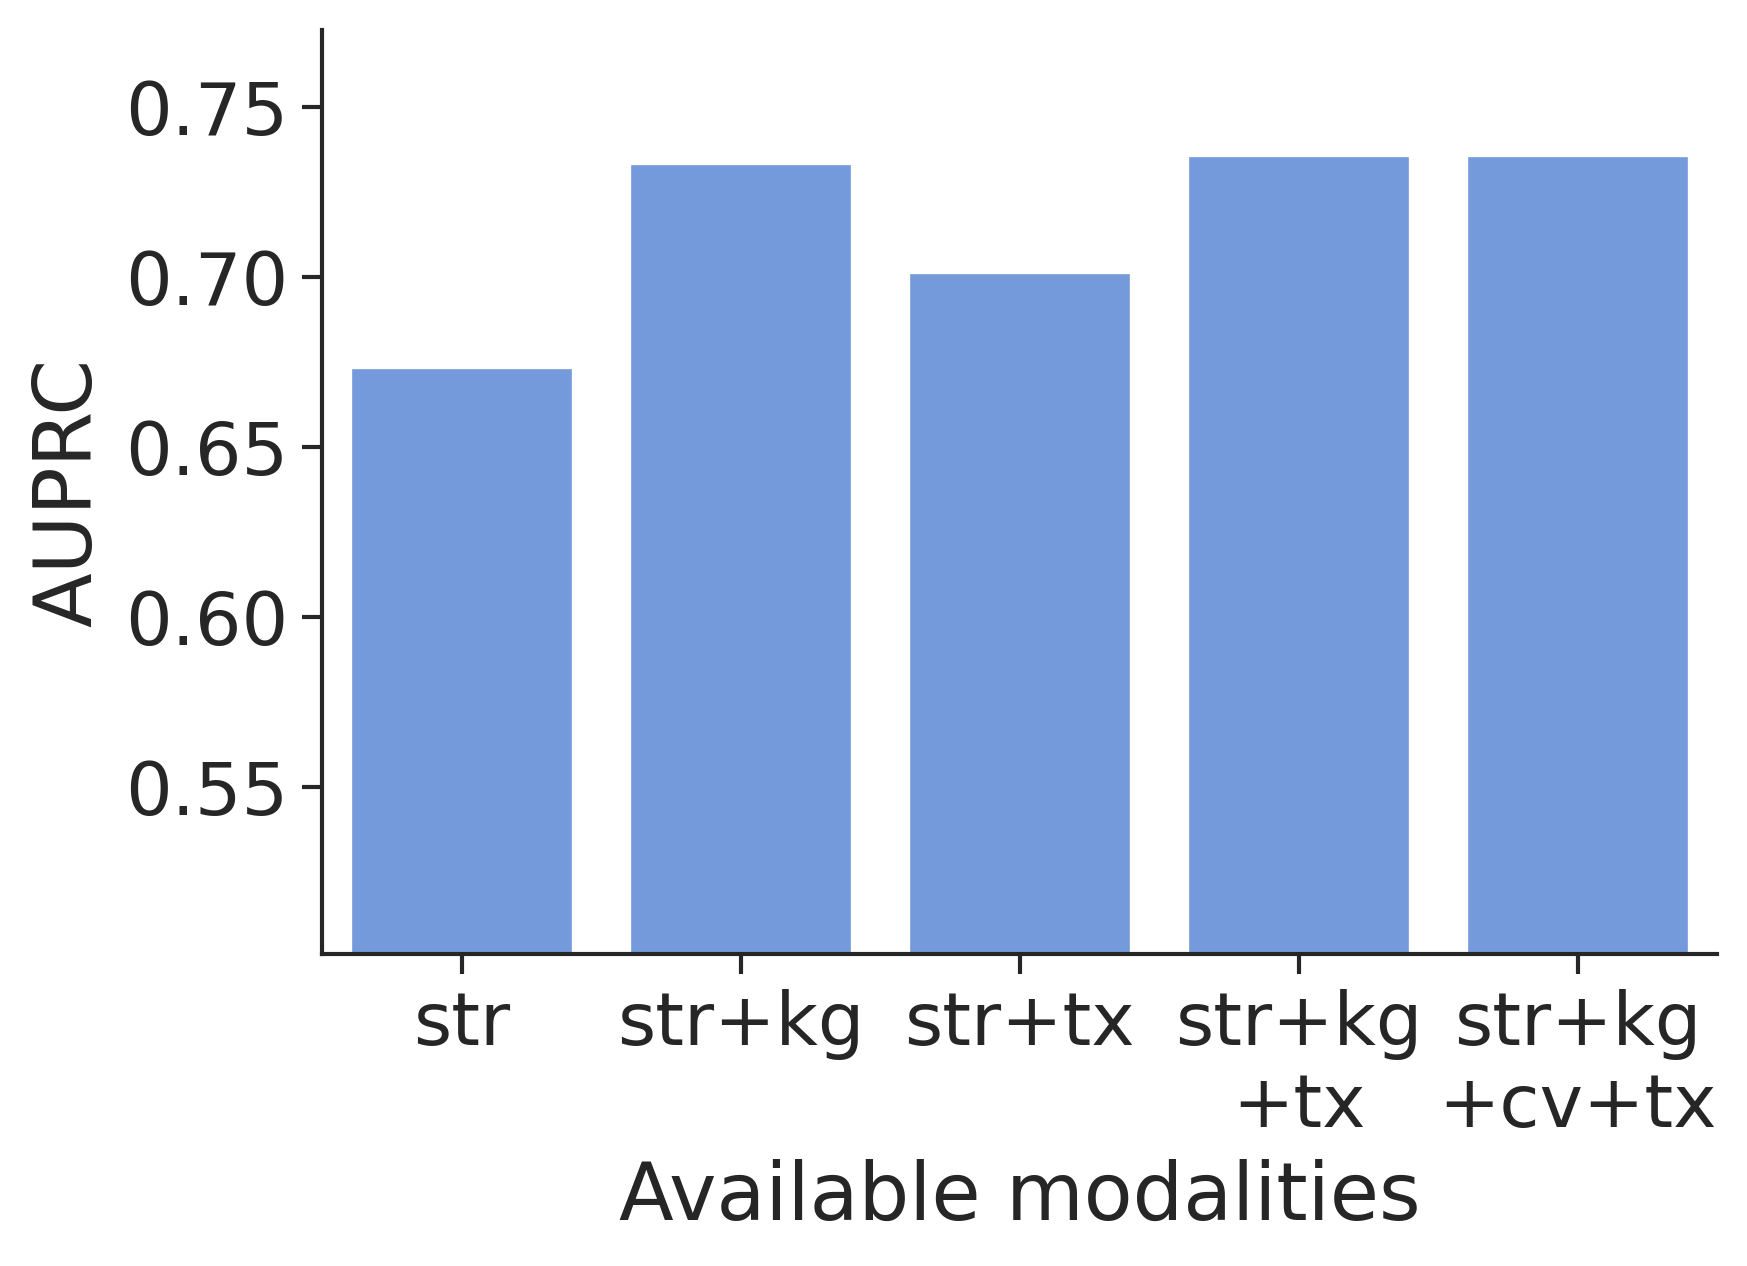

In [ ]:
labels = ['str', 'str+kg', 'str+cv', 'str+tx', 'str+kg\n+cv', 'str+kg\n+tx', 'str+cv\n+tx', 'str+kg\n+cv+tx']

plt.figure(figsize=(6, 4), dpi=300)
sns.set(style="ticks", context="paper", font_scale=2)
sns.barplot(pd.DataFrame.from_dict({
    "AUPRC": mask_train_str_full_all_auprc, "Available modalities": labels
}).iloc[[0, 1, 3, 5, 7], :], x="Available modalities", y="AUPRC", color="cornflowerblue")
plt.ylim(0.501)
sns.despine()
plt.savefig('./fig2_model_perf_str_full_with_diff_avail_mods.svg', dpi=300, format="svg")
plt.show()